# Tucker: Number of components. 
Methods used: DIFFIT, SVD

In [ ]:
import numpy as np
import pandas as pd

import tensorly as tl
from tensorly.decomposition import tucker

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.linalg import svd


# Import tensors

In [ ]:
tensor_70_cent = np.load('tensors_center/tensor_70.npy')
tensor_100_cent = np.load('tensors_center/tensor_100.npy')
tensor_200_cent = np.load('tensors_center/tensor_200.npy')
tensor_300_cent = np.load('tensors_center/tensor_300.npy')

tensors_cent = [tensor_70_cent, tensor_100_cent, tensor_200_cent, tensor_300_cent]
tensor_names_cent = ['70', '100', '200', '300']

# DIFFIT

In [12]:
best_ranks = []
best_fits = []
valid_ranks = []
tensor = tensor_70_cent # change tensor
model = tucker # change model

for i in range(1, tensor.shape[0]+1):
    for j in range(1, tensor.shape[1]+1):
        for k in range(1, tensor.shape[2]+1):
            if i <= j*k and j <= i*k and k <= i*j:
                valid_ranks.append([i, j, k])

valid_ranks = np.array(valid_ranks)

unique_s = np.unique(np.sum(valid_ranks, axis=1))

for s in unique_s:
    ranks_s = valid_ranks[np.sum(valid_ranks, axis=1) == s]

    best_fit = 0
    best_rank = []

    for rank in ranks_s:
        core_tensor, factors = model(tensor, list(rank))

        reconstructed_tensor = tl.tucker_to_tensor((core_tensor, factors))

        fit = 100 * (np.sum(tensor**2) - np.sum((tensor - reconstructed_tensor)**2)) / np.sum(tensor**2)

        if fit > best_fit:
            best_fit = fit
            best_rank = rank

    best_ranks.append(best_rank)
    best_fits.append(best_fit)

In [13]:
df = pd.DataFrame(best_ranks, columns=['P', 'Q', 'R'])
df['Fit'] = best_fits
df.to_csv('best_ranks_and_fits.csv', index=False)

# SVD 

In [52]:
# Set global font sizes
plt.rcParams.update({
    "font.size": 22,        # Default text size
    "axes.titlesize": 22,   # Title size
    "axes.labelsize": 22,   # X and Y label size
    "xtick.labelsize": 20,  # X tick labels
    "ytick.labelsize": 20,  # Y tick labels
    "legend.fontsize": 19,  # Legend text size
    "figure.titlesize": 23,  # Suptitle font size
    "lines.linewidth": 3  # Increase line thickness
})

In [53]:
def error(original, res):
    """Computes the error difference"""
    assert original.shape == res.shape
    return np.sum((original - res)**2) / np.sum(original**2)

def reconstruction_errors(ranks, U, S, Vt, matricized):
    """Computes the reconstruction error"""
    errors=np.zeros_like(ranks, dtype=float)
    for i, r in enumerate(ranks):
        reconstructed = (U[:, :r] @ np.diag(S[:r]) @ Vt[:r, :])
        errors[i] = error(matricized, reconstructed)
    return errors

In [66]:
def compute_svd_ranks(tensor, tensor_name, error_threshold=0.05):
    """
    Computes the optimal rank for each mode using SVD, selecting ranks based on reconstruction error.
    Highlights selected singular values in the bar plots.
    """
    folder = 'C:/AQUI ESTA LO WENO/UNI/Chalmers/TFM/Data and Code/Results/Tucker components'
    thres_rank = []

    # Define plots (Reconstruction error and singular values)
    fig, axes = plt.subplots(1, 3, figsize=(18, 3))
    fig.subplots_adjust(wspace=0.5, hspace=0.4, bottom=0.1)
    fig.suptitle(f"Reconstruction Error for tensor_{tensor_name}", y=1.12)

    fig2, axes2 = plt.subplots(1, 3, figsize=(18, 3))
    fig2.subplots_adjust(wspace=0.5, hspace=0.4, bottom=0.1)
    fig2.suptitle(f"Singular Values for tensor_{tensor_name}", y=1.12)

    # Find the number of components per each mode
    for mode in range(tl.ndim(tensor)):
        matricized = tl.unfold(tensor, mode)
        U, S, Vt = svd(matricized, full_matrices=False)
              
        ranks = np.arange(1, len(S) + 1)

        errors = reconstruction_errors(ranks, U, S, Vt, matricized)

        selected_rank = np.where(errors < error_threshold)[0][0] + 1  # Add 1 because index 0 corresponds to 1 component
        thres_rank.append(selected_rank)

        # Error plots
        ax = axes[mode]
        ax.plot(ranks, errors, color='b', marker='o', linestyle='-', label="Reconstruction Error", linewidth=3)
        ax.axvline(x=selected_rank, color='r', linestyle='--', label=f'Threshold ({error_threshold})', linewidth=3)
        ax.set_xlabel("Num of Comps.")
        ax.set_title(f"Mode {mode}")
        ax.grid(False)

        # Singular values plots (with highlighting)
        bar_colors = ['orange' if i < selected_rank else 'lightgray' for i in range(len(S))]
        axes2[mode].bar(np.arange(1, len(S) + 1), S, color=bar_colors)
        axes2[mode].set_xlabel('Component')
        axes2[mode].set_title(f"Mode {mode}")
        axes2[mode].grid(False)

    # Set the same y-label for all subplots
    axes[0].set_ylabel("Error")
    axes2[0].set_ylabel('Magnitude')

    # Add legends to the first plot
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="lower center", bbox_to_anchor=(0.5, -0.35), ncol=3)

    # Save figures
    fig.savefig(f"{folder}/tensor_{tensor_name}_reconstruction_error_{error_threshold}.png", format="png", bbox_inches="tight")
    fig.savefig(f"{folder}/tensor_{tensor_name}_reconstruction_error_{error_threshold}.pdf", format="pdf", bbox_inches="tight")

    fig2.savefig(f"{folder}/tensor_{tensor_name}_singular_values_{error_threshold}.png", format="png", bbox_inches="tight")
    fig2.savefig(f"{folder}/tensor_{tensor_name}_singular_values_{error_threshold}.pdf", format="pdf", bbox_inches="tight")
    
    plt.show()
    return thres_rank


In [67]:
def SVD_components(tensors_cent, error_threshold=0.1):
    all_errors = []

    for i, tensor in enumerate(tensors_cent):
        tensor_name = tensor_names_cent[i]
        error_thres_ranks = compute_svd_ranks(tensor, tensor_name, error_threshold=error_threshold)
        all_errors.append(error_thres_ranks)

    return all_errors



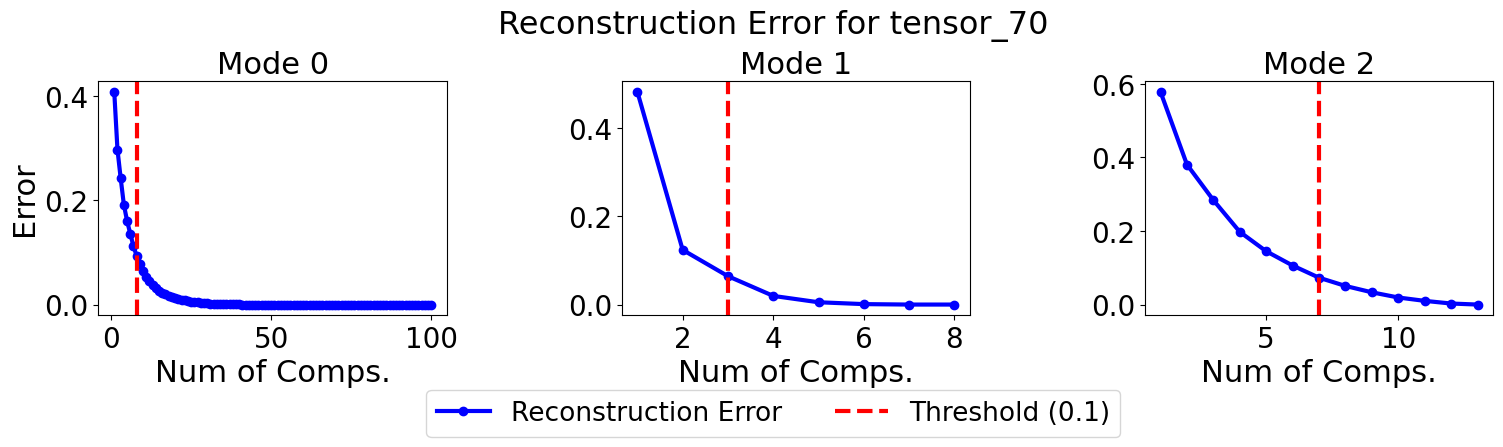

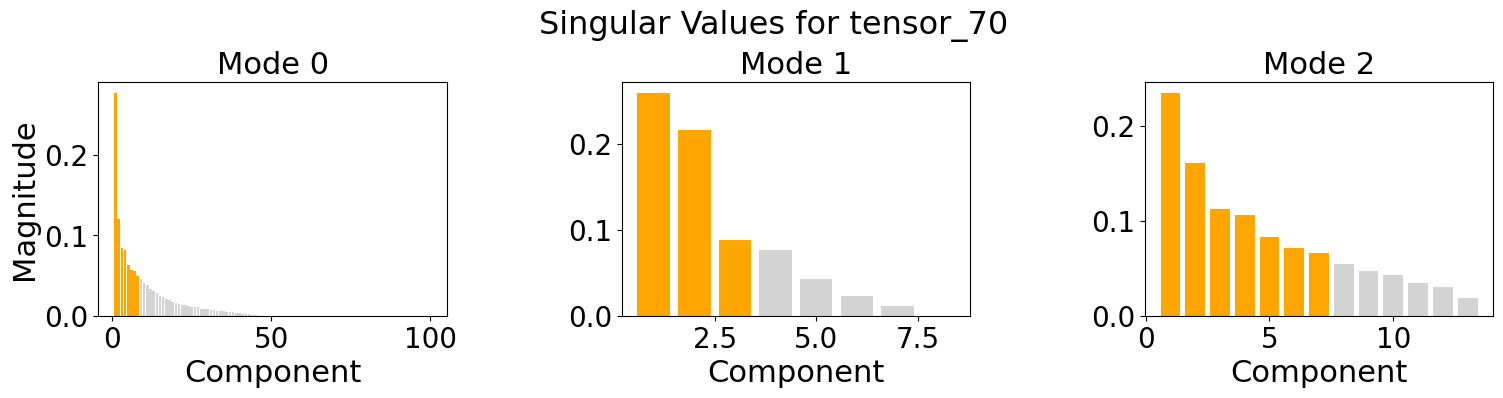

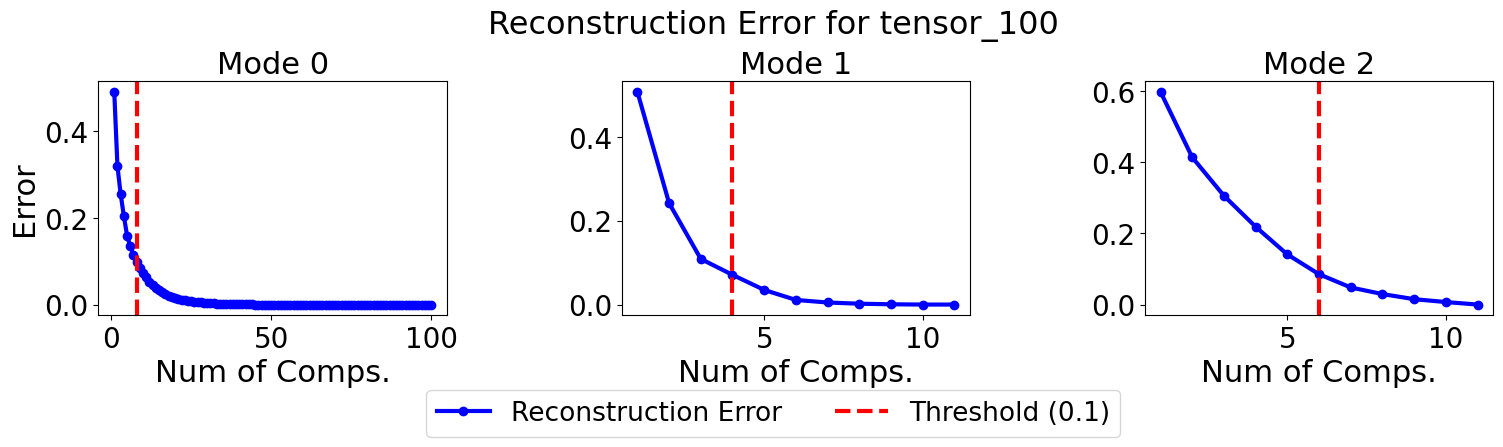

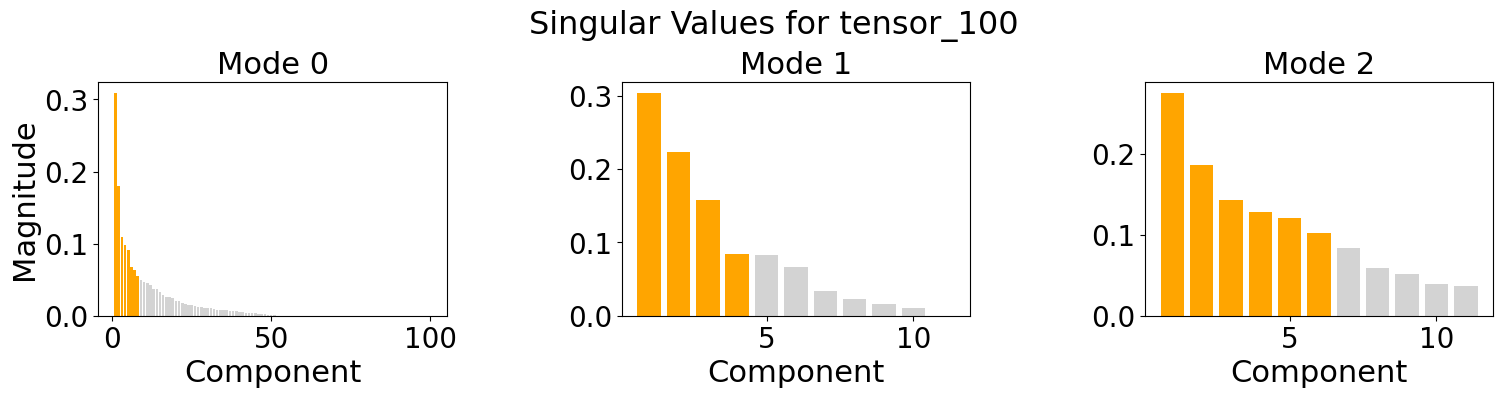

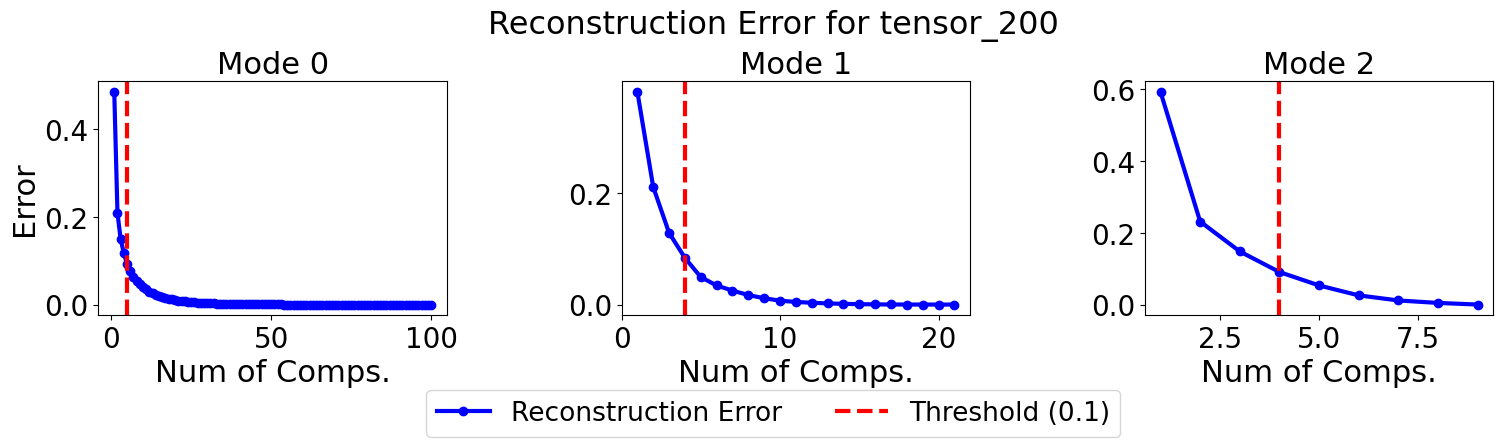

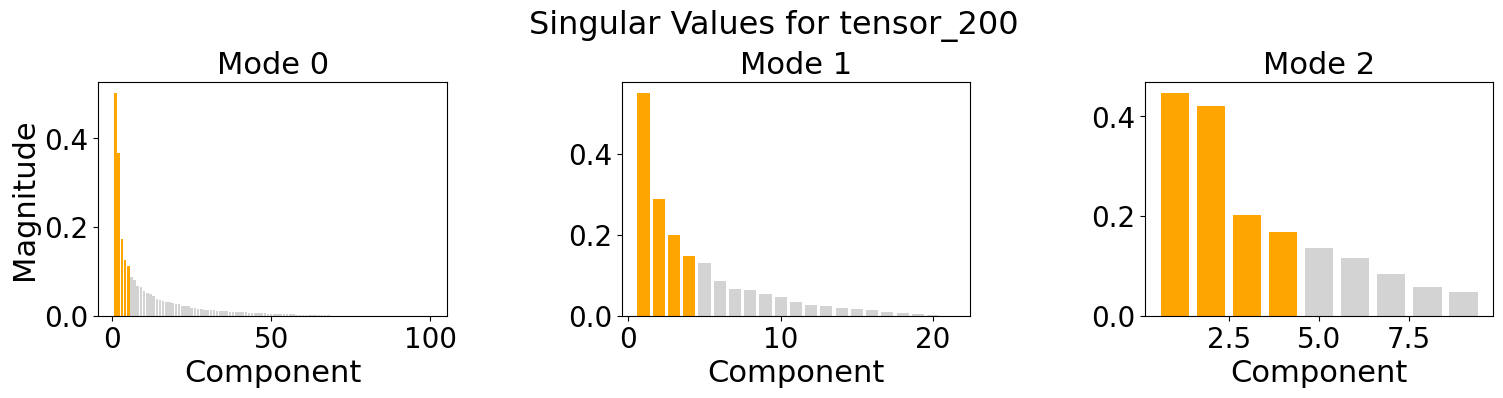

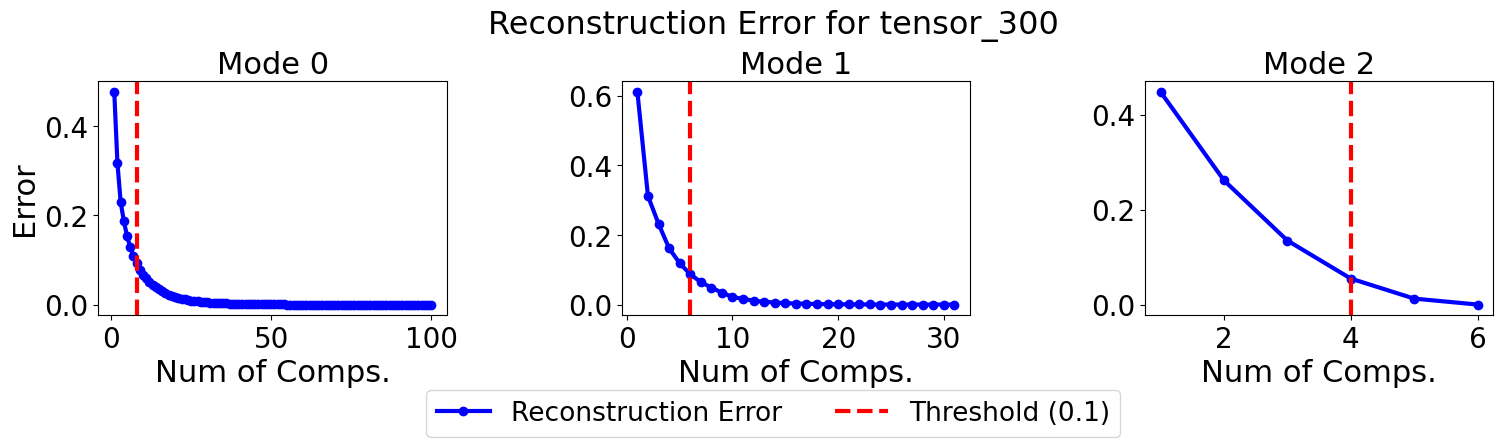

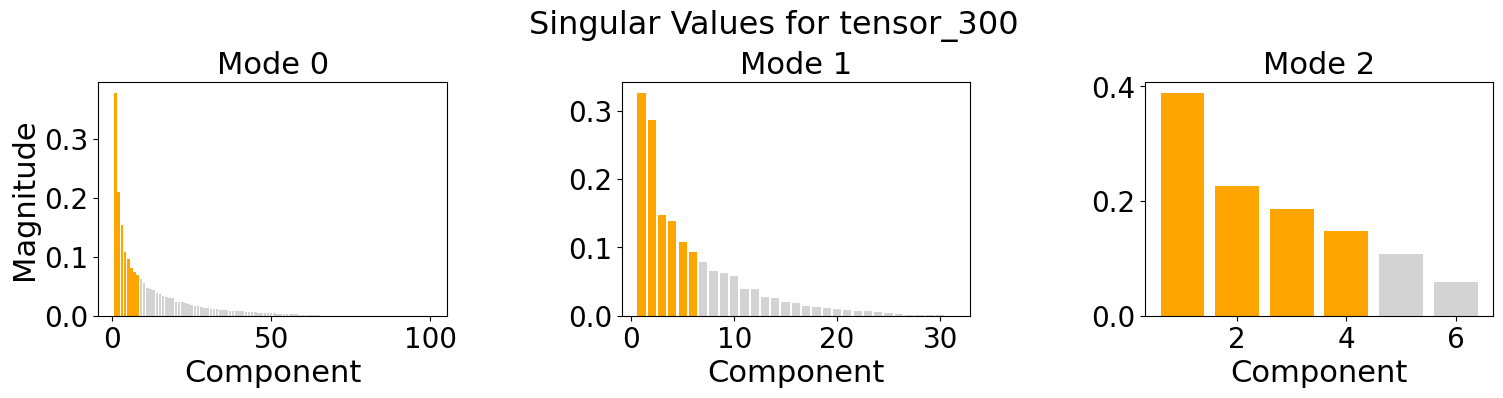

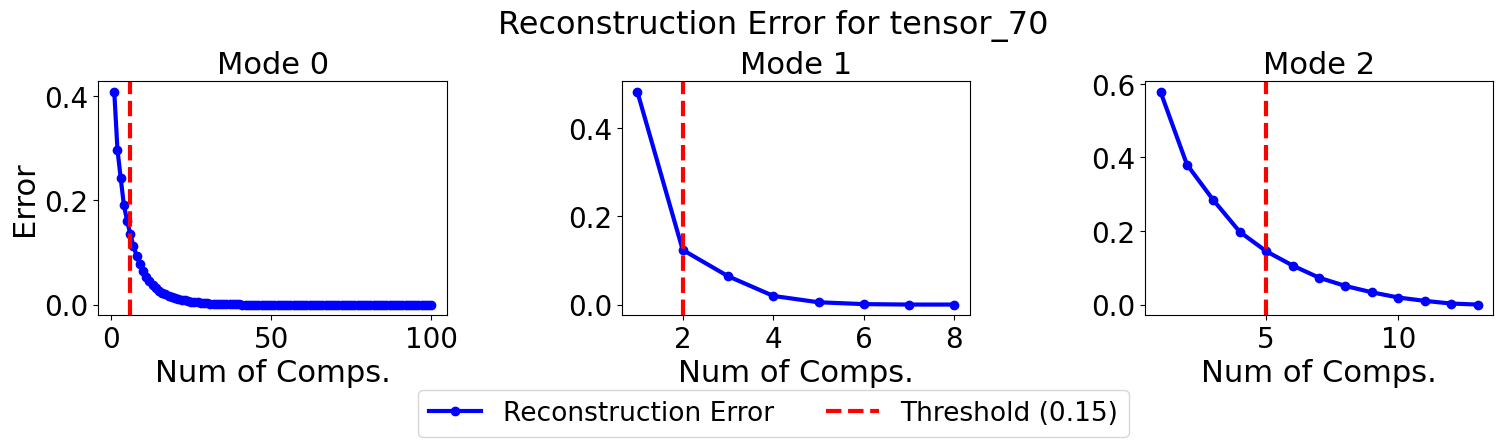

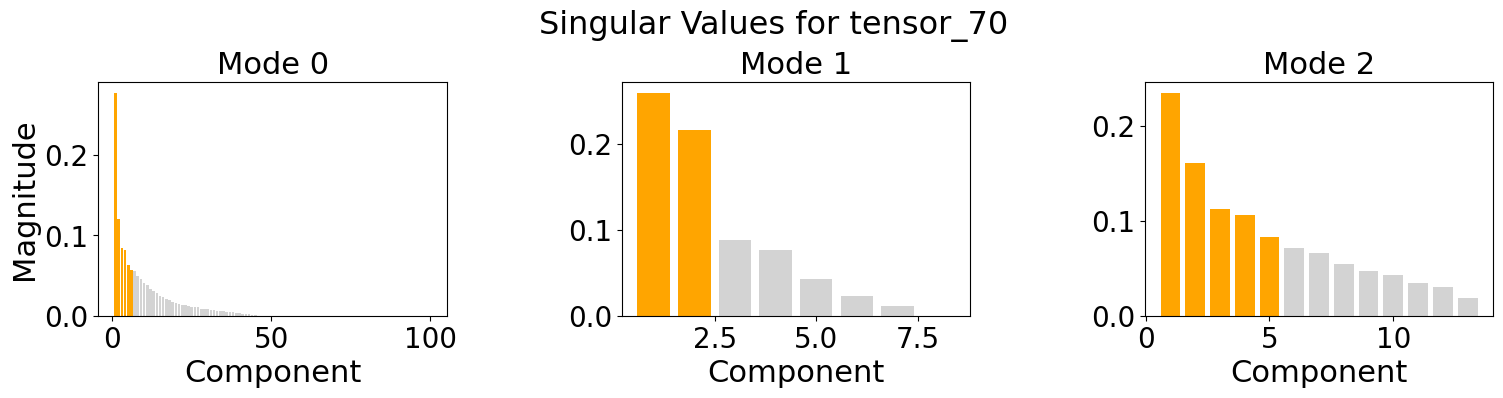

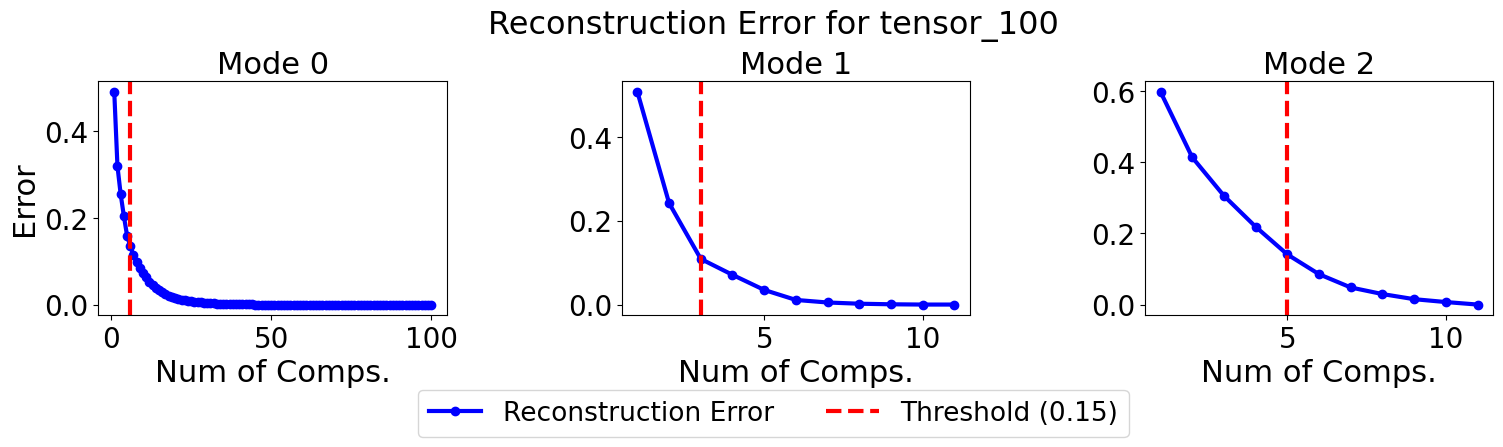

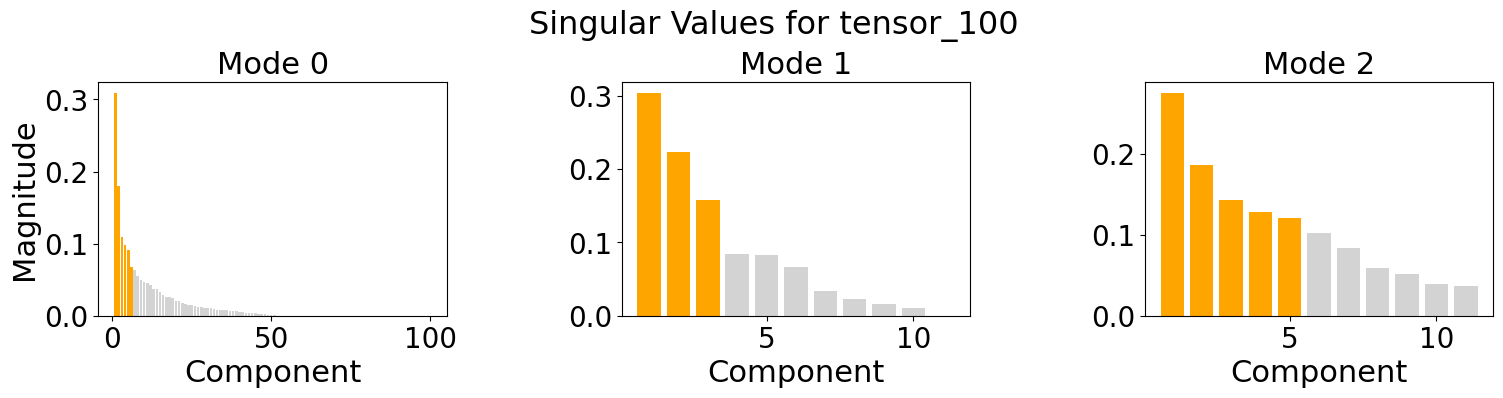

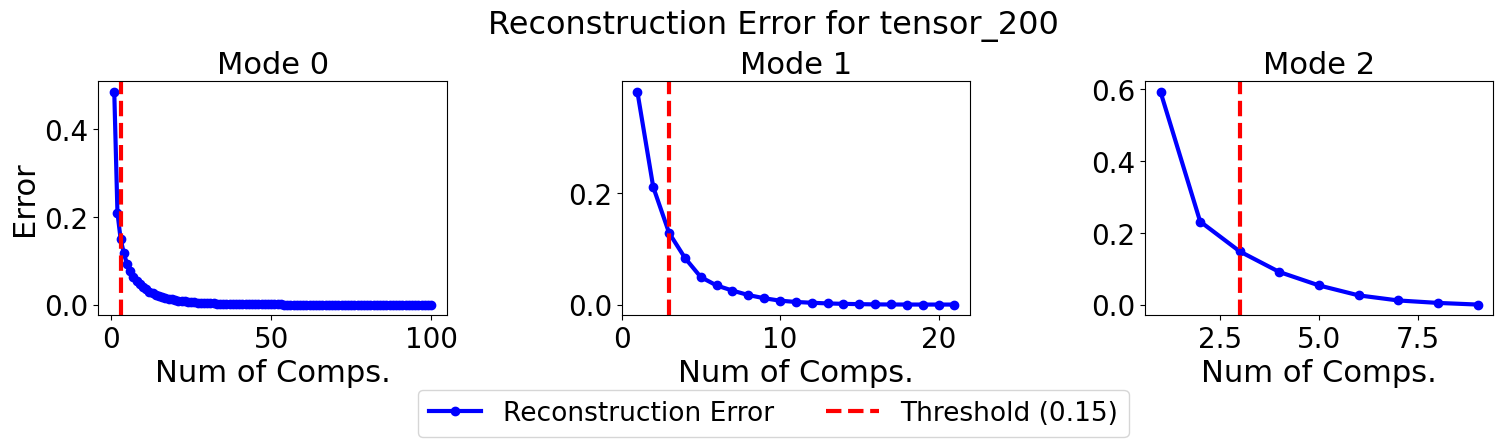

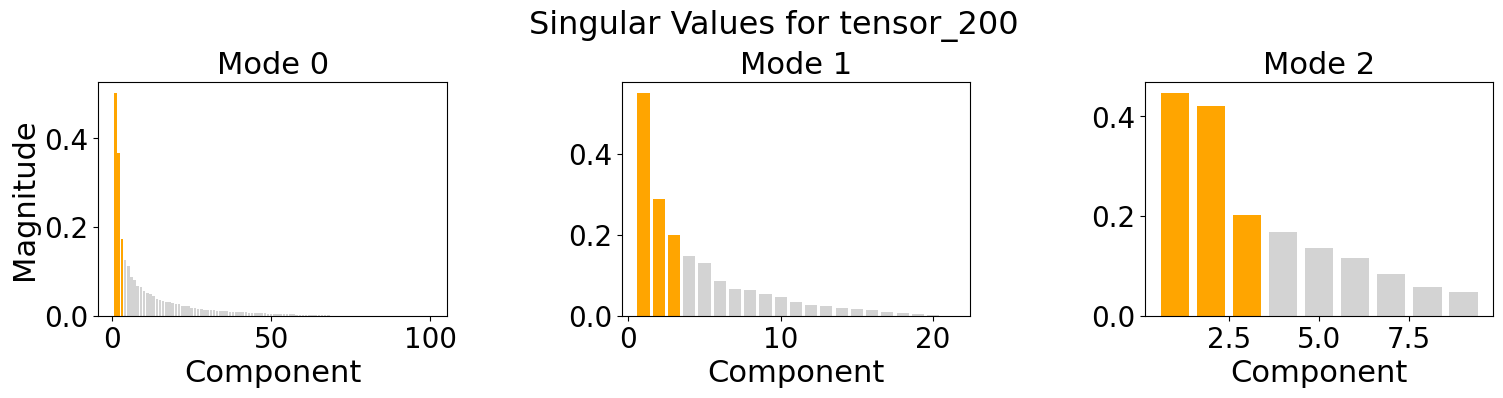

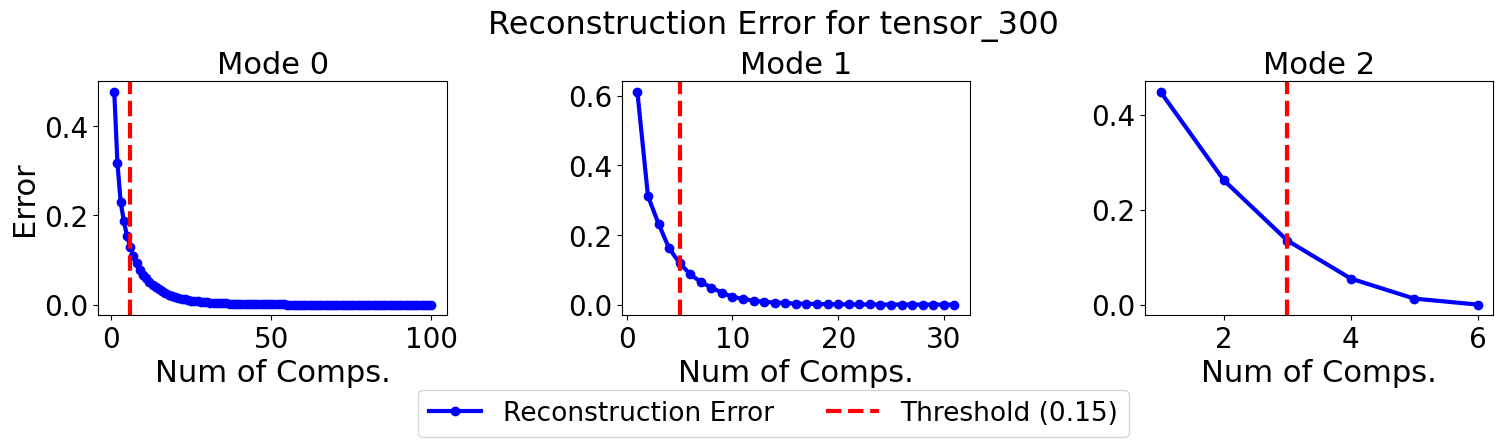

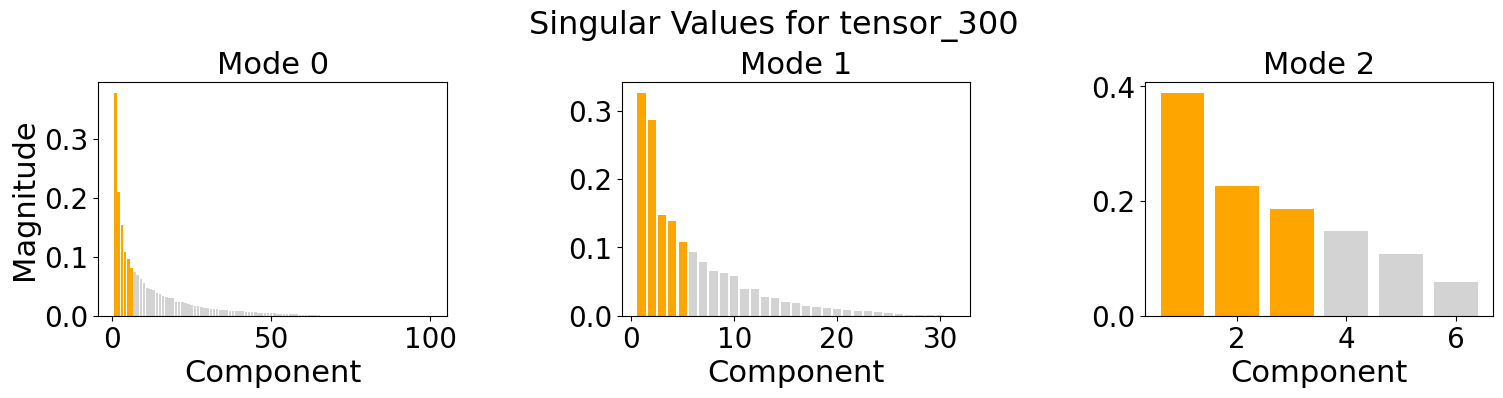

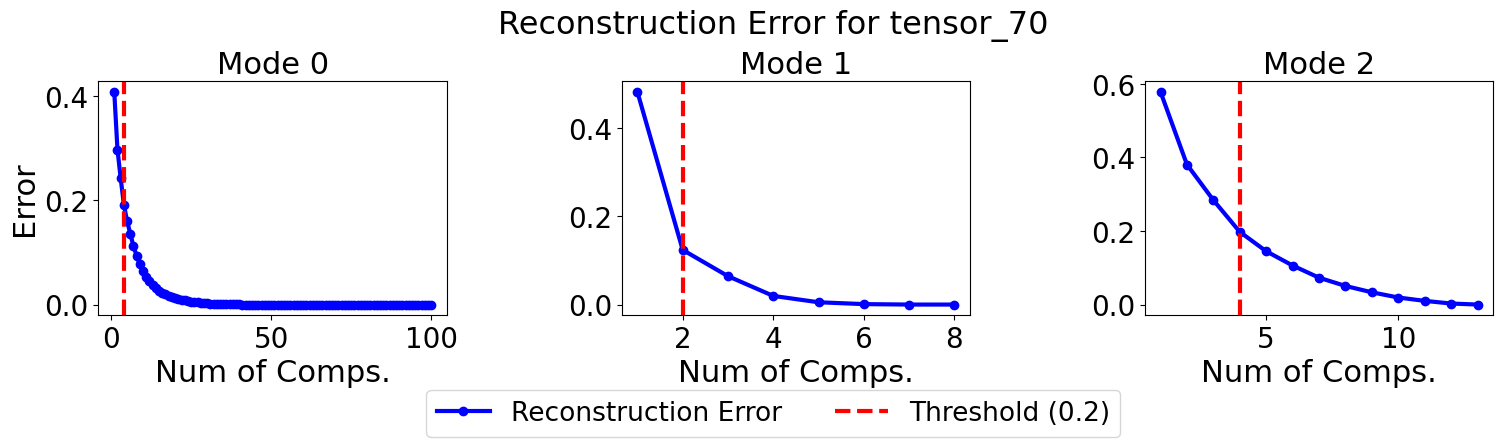

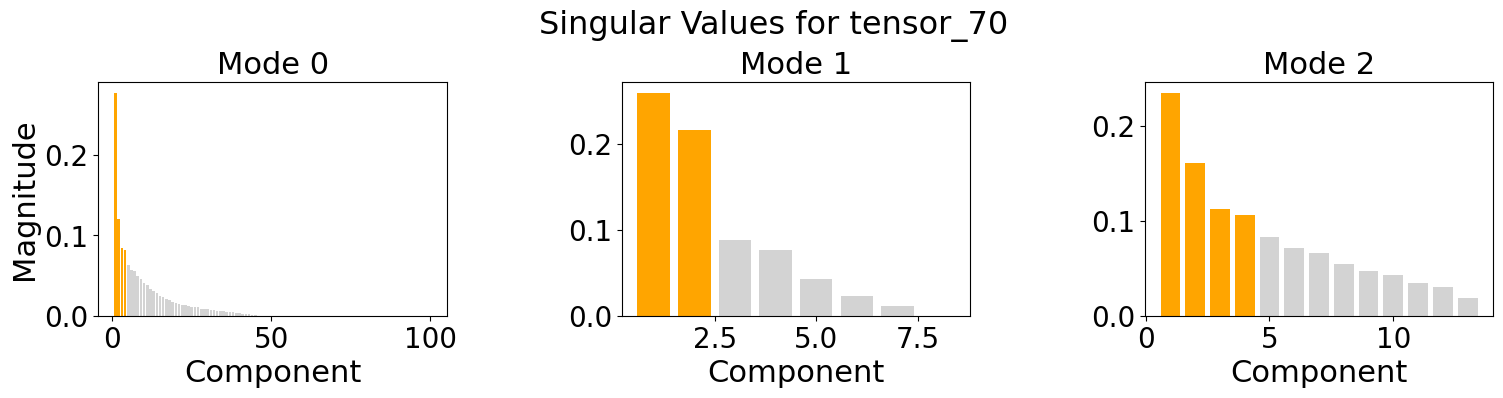

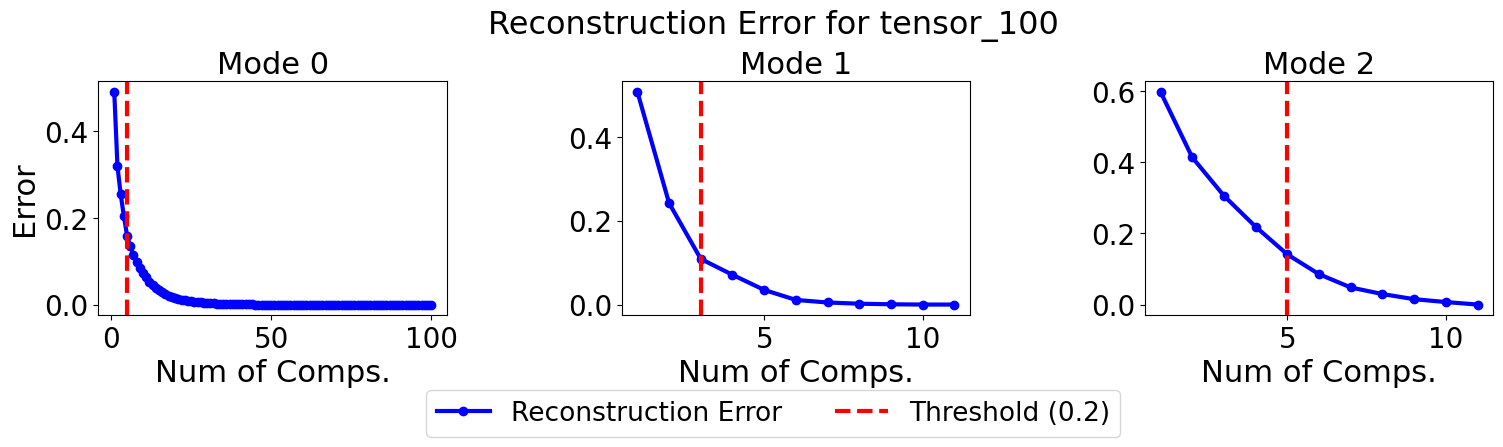

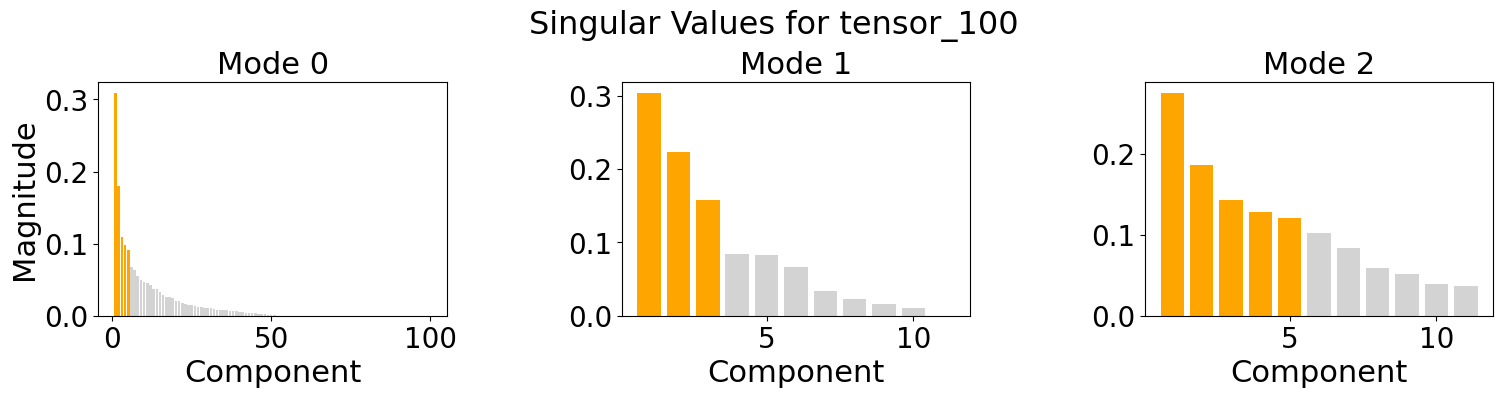

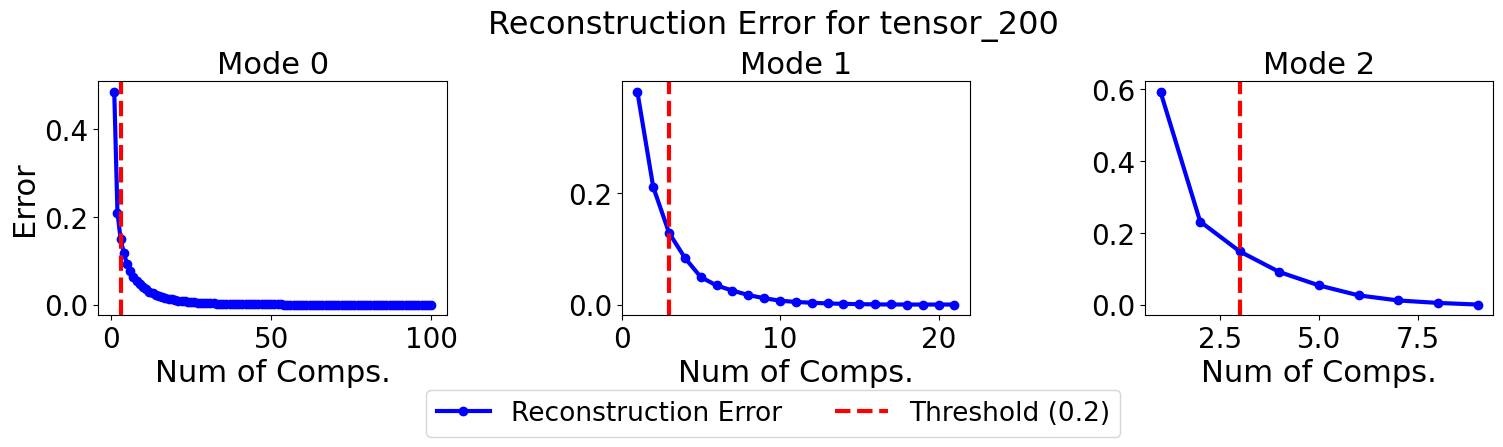

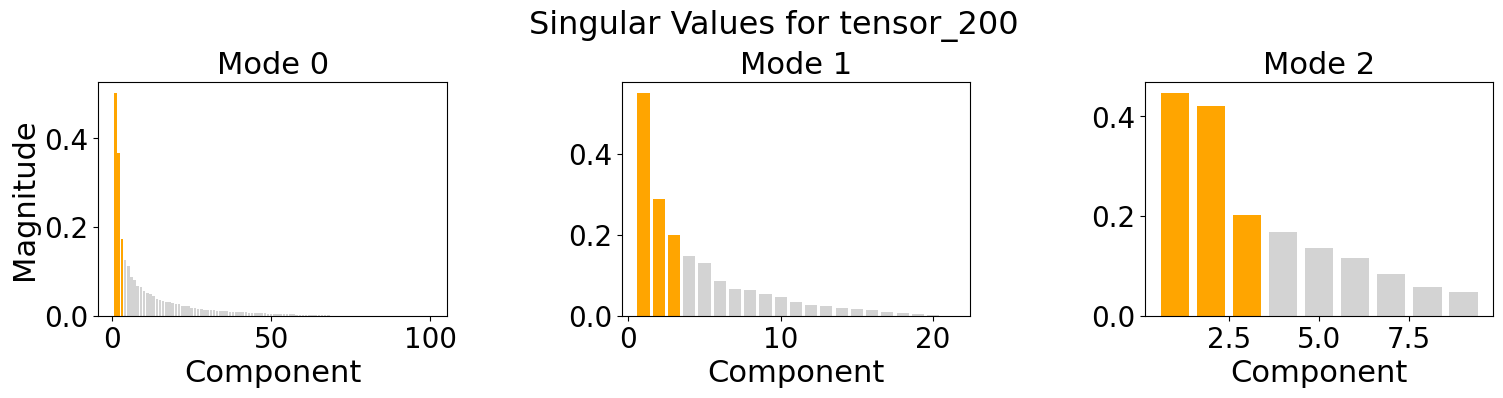

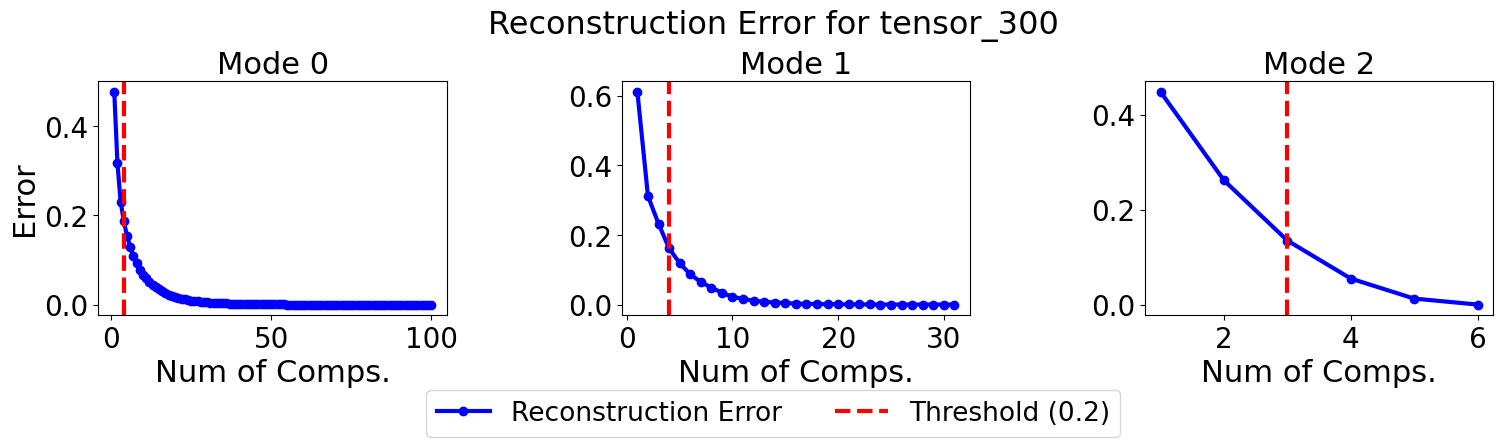

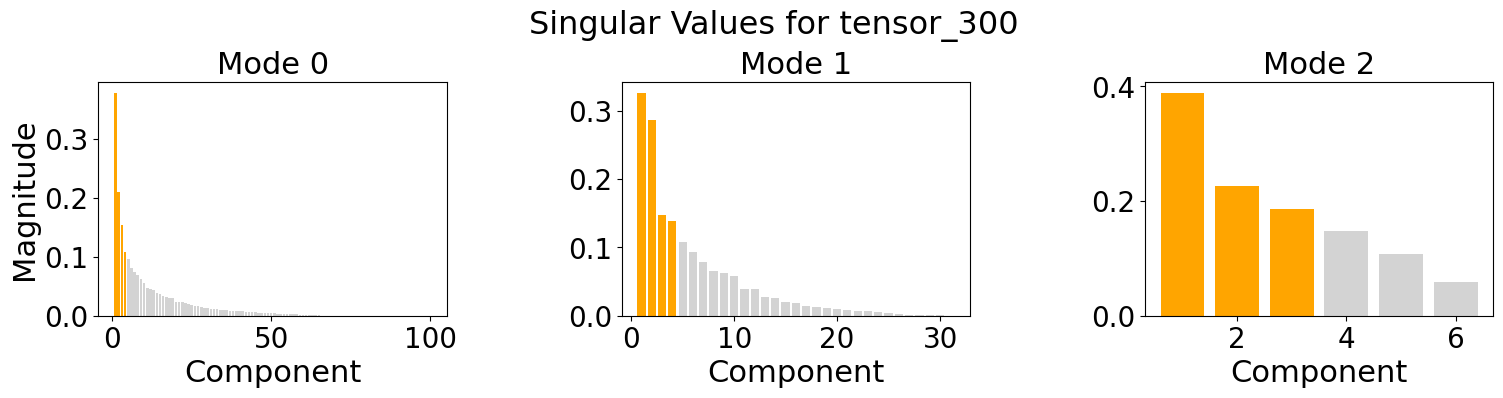

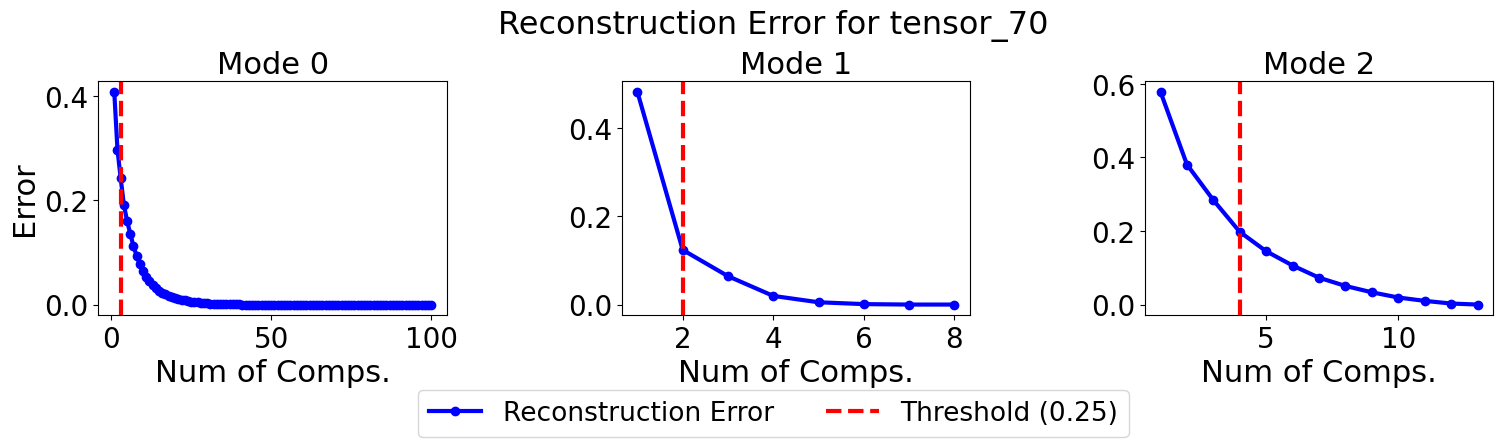

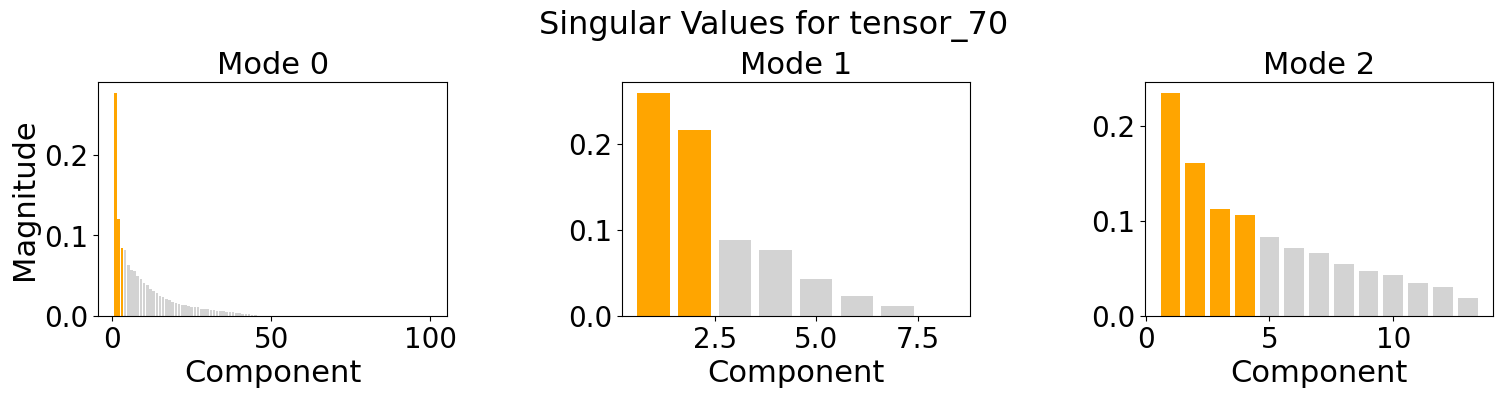

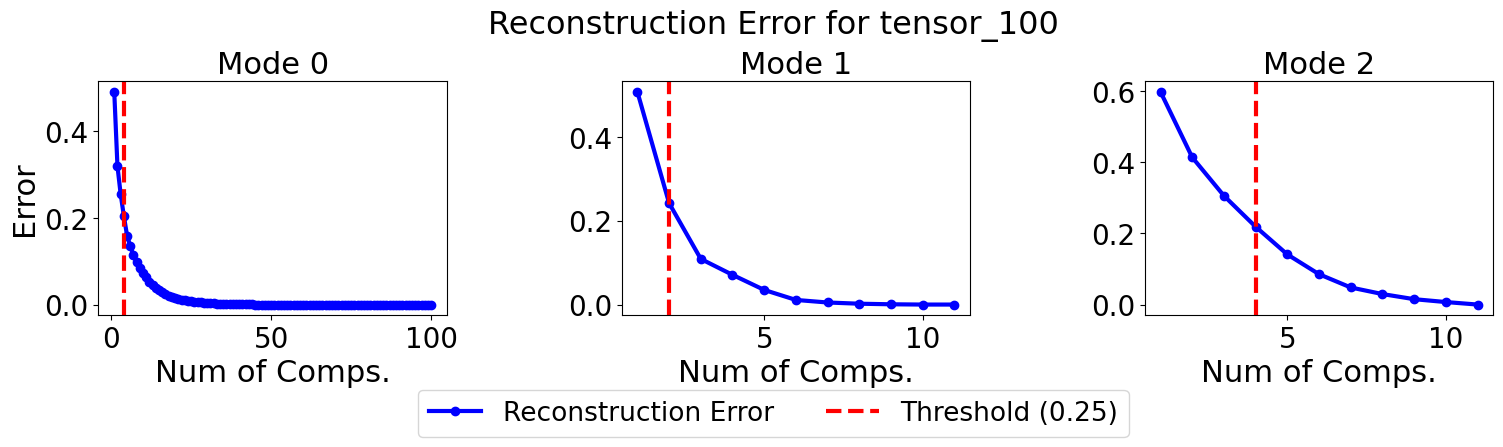

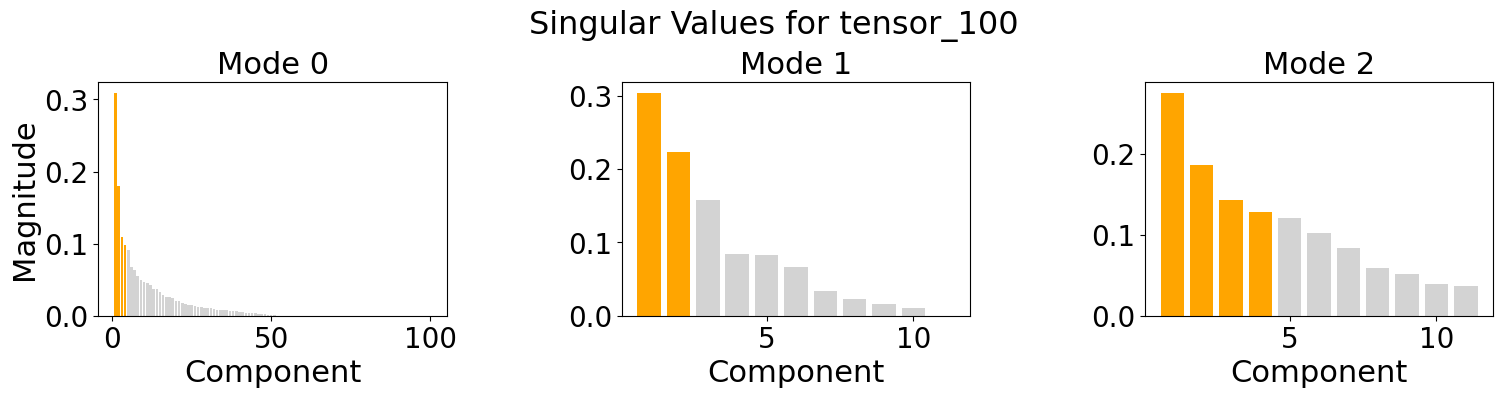

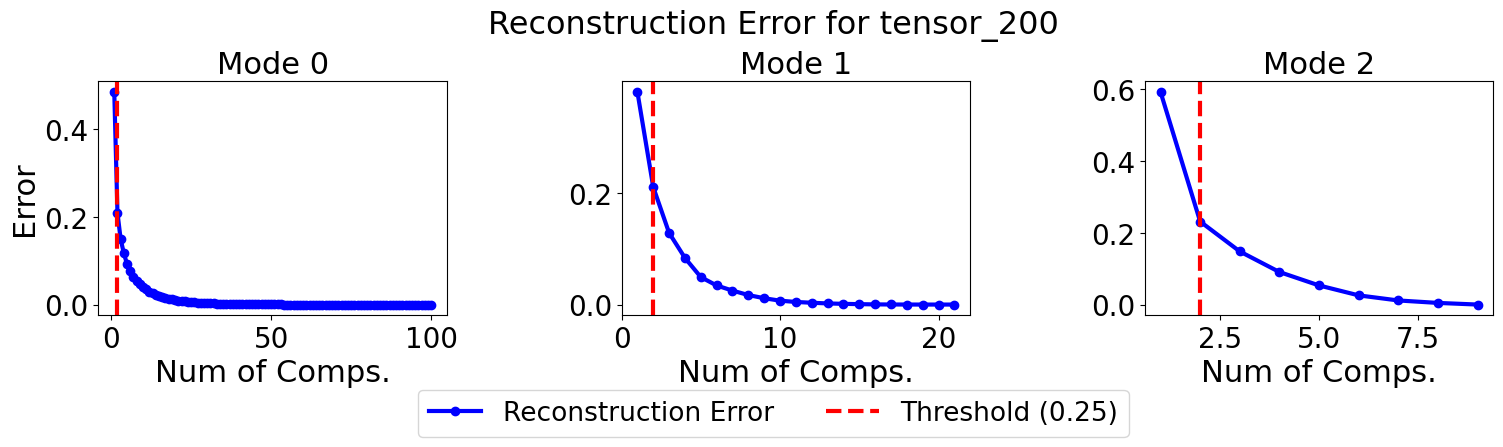

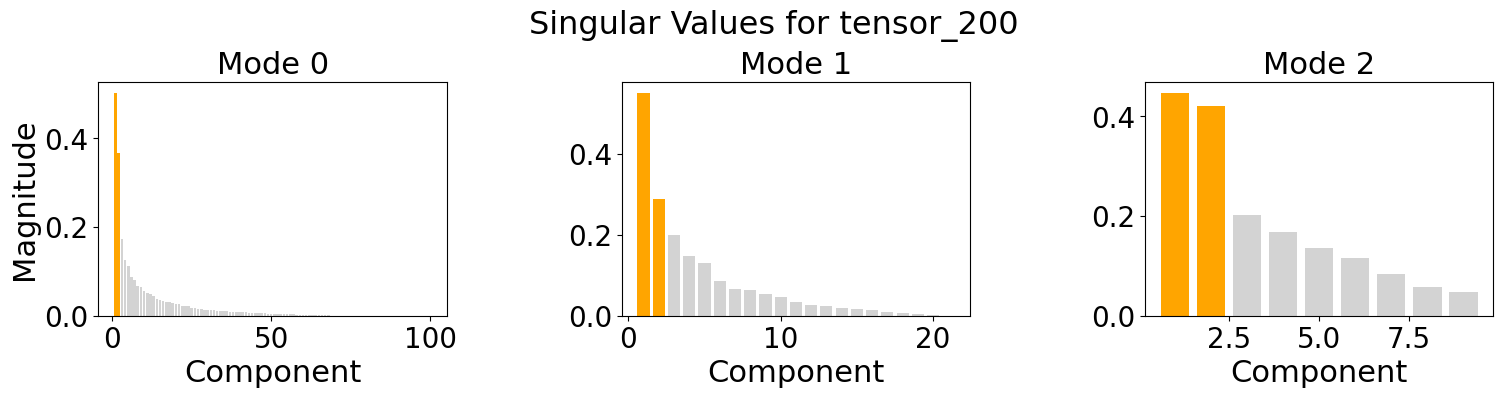

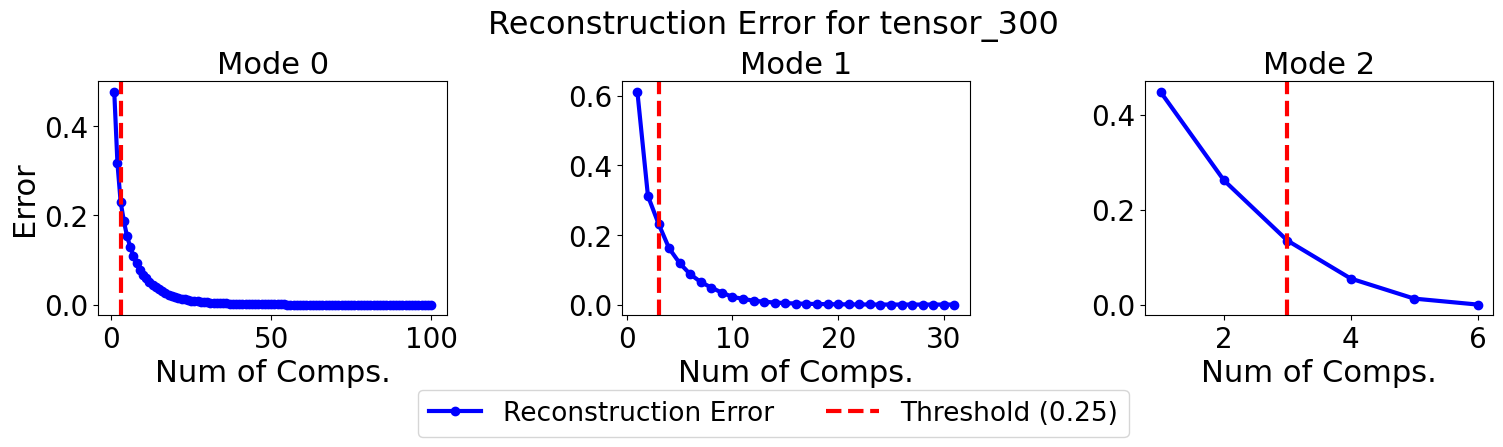

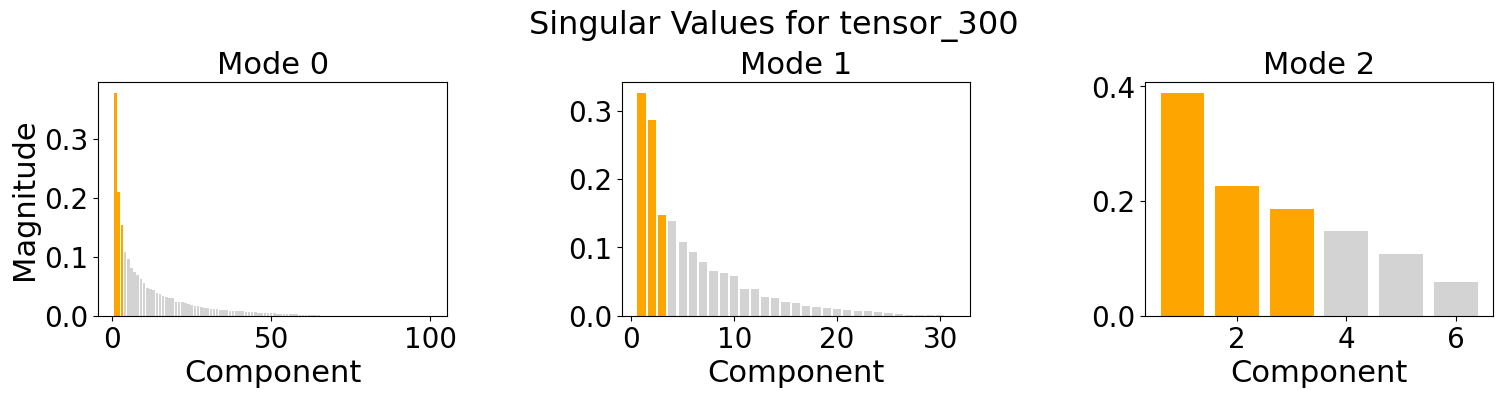

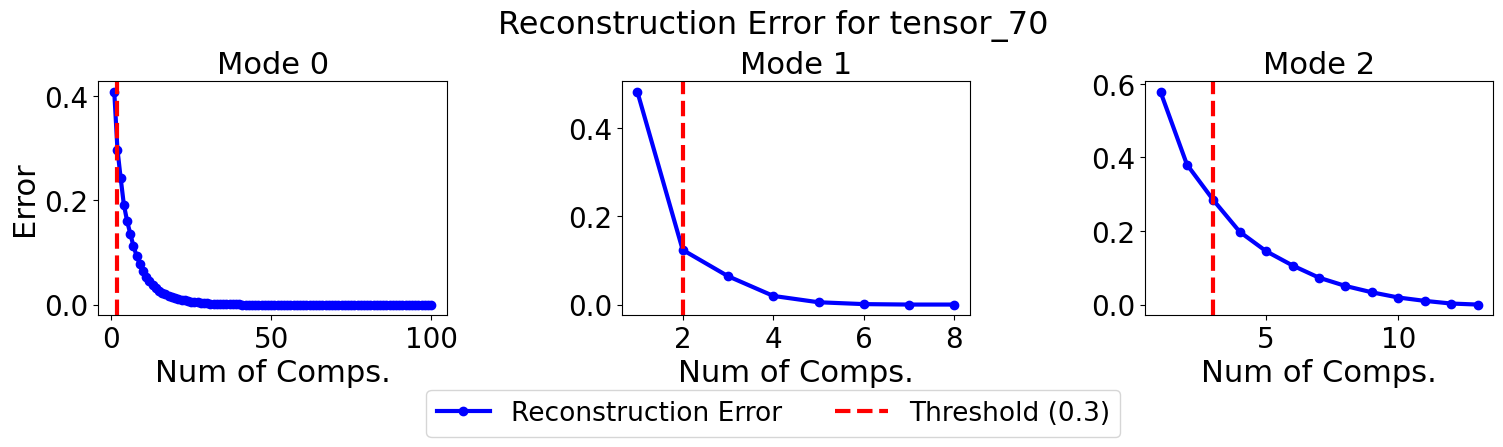

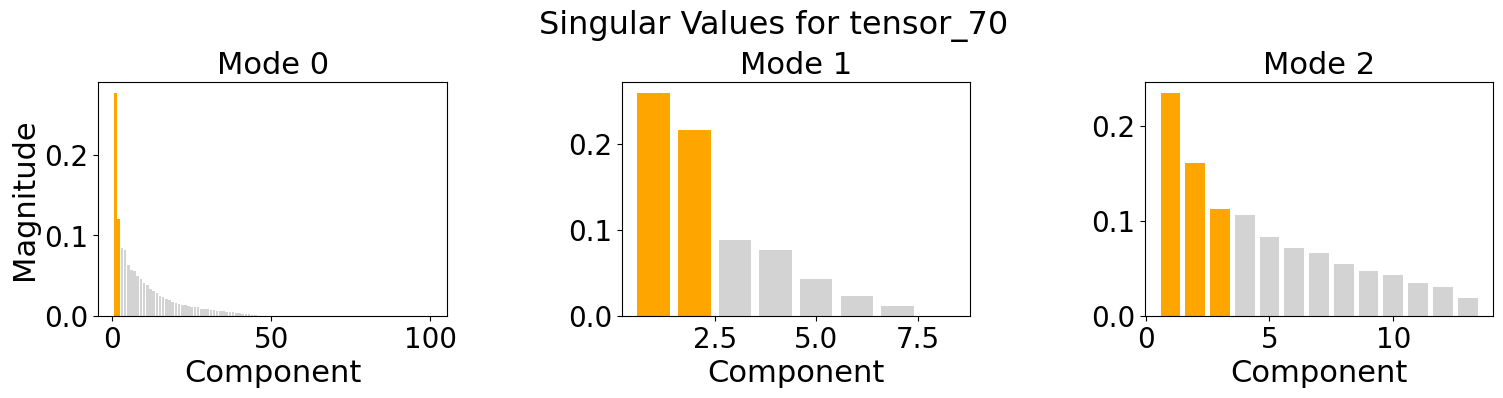

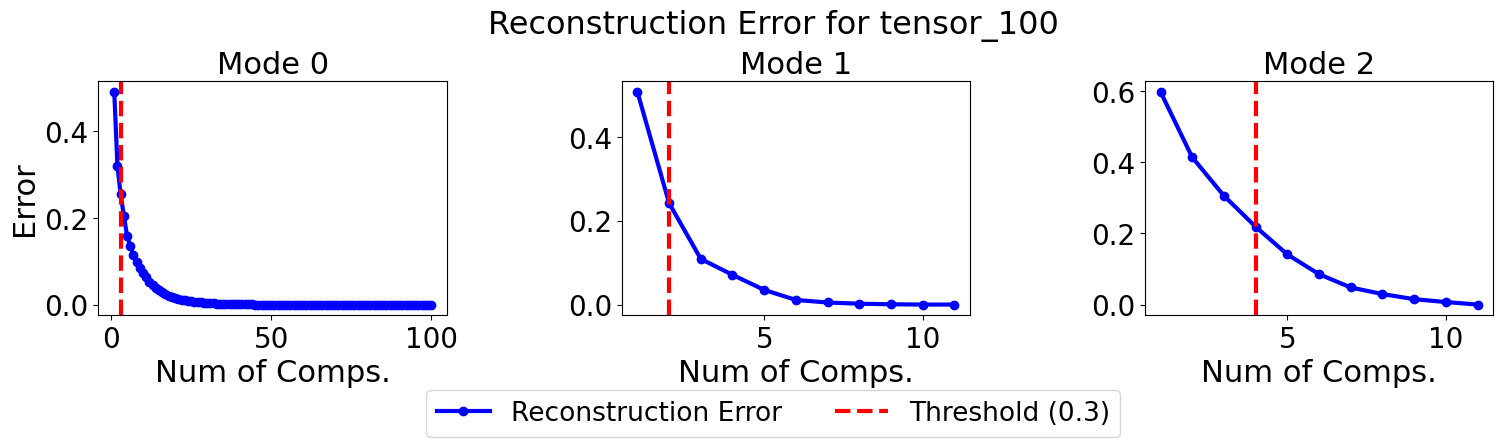

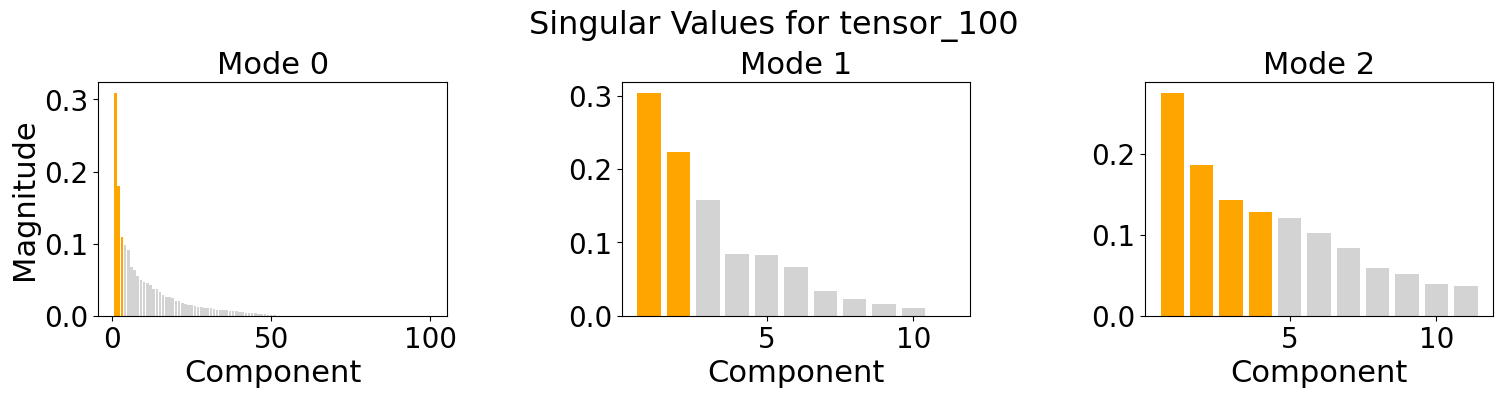

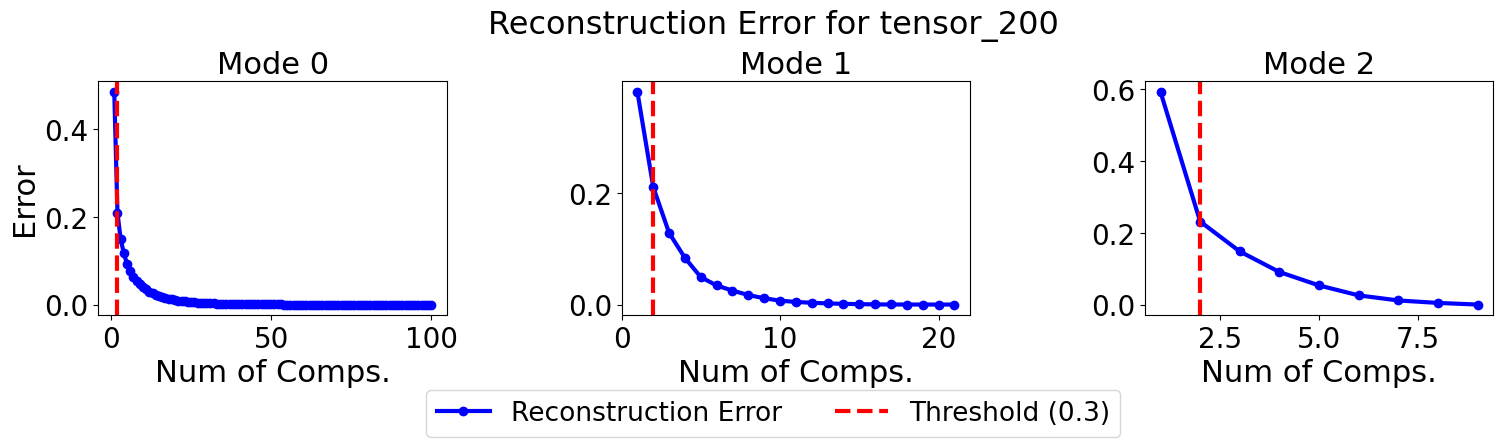

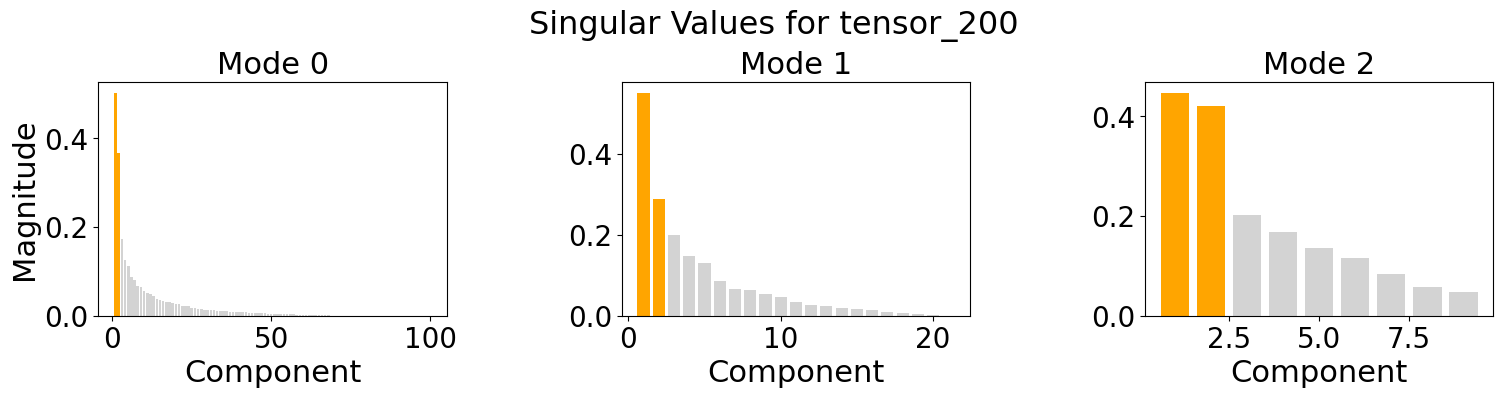

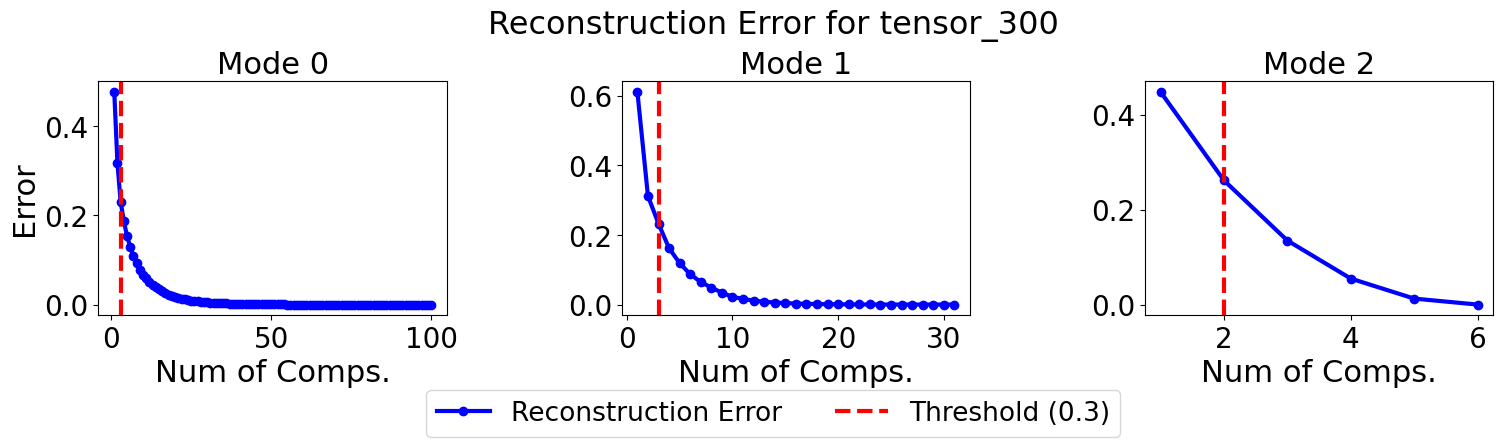

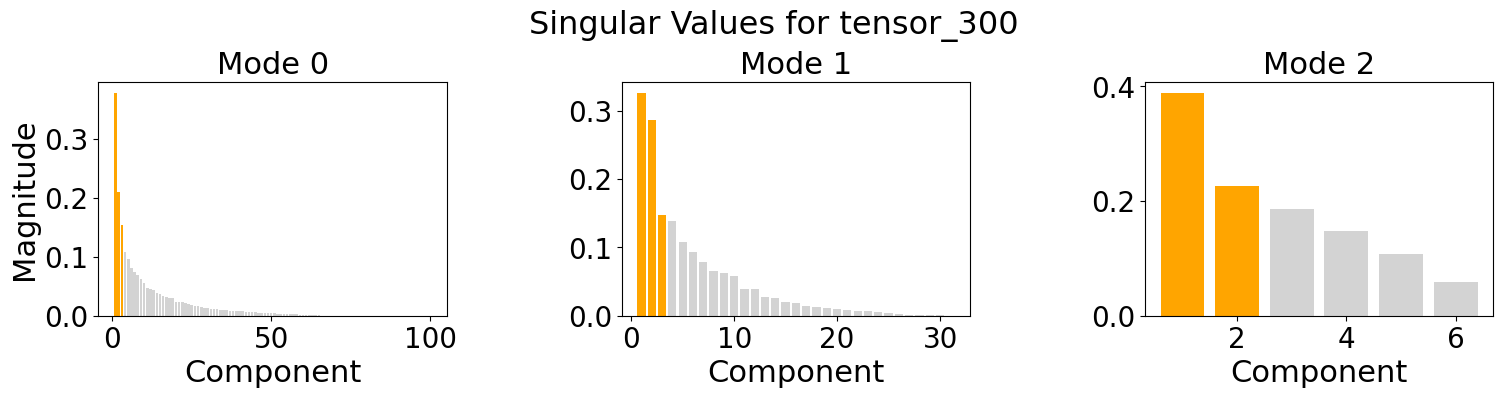


Results for threshold = 0.1
Final Ranks for tensor_70 (threshold=0.1): [8, 3, 7]
Final Ranks for tensor_100 (threshold=0.1): [8, 4, 6]
Final Ranks for tensor_200 (threshold=0.1): [5, 4, 4]
Final Ranks for tensor_300 (threshold=0.1): [8, 6, 4]

Results for threshold = 0.15
Final Ranks for tensor_70 (threshold=0.15): [6, 2, 5]
Final Ranks for tensor_100 (threshold=0.15): [6, 3, 5]
Final Ranks for tensor_200 (threshold=0.15): [3, 3, 3]
Final Ranks for tensor_300 (threshold=0.15): [6, 5, 3]

Results for threshold = 0.2
Final Ranks for tensor_70 (threshold=0.2): [4, 2, 4]
Final Ranks for tensor_100 (threshold=0.2): [5, 3, 5]
Final Ranks for tensor_200 (threshold=0.2): [3, 3, 3]
Final Ranks for tensor_300 (threshold=0.2): [4, 4, 3]

Results for threshold = 0.25
Final Ranks for tensor_70 (threshold=0.25): [3, 2, 4]
Final Ranks for tensor_100 (threshold=0.25): [4, 2, 4]
Final Ranks for tensor_200 (threshold=0.25): [2, 2, 2]
Final Ranks for tensor_300 (threshold=0.25): [3, 3, 3]

Results for t

In [68]:
thresholds = [0.1, 0.15, 0.2, 0.25, 0.3]
all_errors_by_threshold = {}

# Run SVD_components for each threshold
for threshold in thresholds:
    errors = SVD_components(tensors_cent, error_threshold=threshold)
    all_errors_by_threshold[threshold] = errors

# Now print nicely
for threshold, errors in all_errors_by_threshold.items():
    print(f"\nResults for threshold = {threshold}")
    for j, tensor in enumerate(tensors_cent):
        tensor_name = tensor_names_cent[j]
        print(f"Final Ranks for tensor_{tensor_name} (threshold={threshold}): {errors[j]}")


# Saving results

In [ ]:
import pickle

# Build final_ranks from the threshold results
final_ranks = {}

for threshold, tensor_errors in all_errors_by_threshold.items():
    for j, ranks in enumerate(tensor_errors):
        tensor_name = f"tensor_{tensor_names_cent[j]}"
        if tensor_name not in final_ranks:
            final_ranks[tensor_name] = []
        final_ranks[tensor_name].append(ranks)

# Manually input DIFIT results
results_difit = {
    'tensor_70': [[1,2,2],[2,2,3]],
    'tensor_100': [[2,2,2],[2,2,3],[5,3,6]],
    'tensor_200': [[2,2,2]],
    'tensor_300': [[4,4,4],[3,3,3]]
}

# Add DIFIT results into final_ranks
for tensor_name, difit_ranks_list in results_difit.items():
    if tensor_name not in final_ranks:
        final_ranks[tensor_name] = []
    final_ranks[tensor_name].extend(difit_ranks_list)

# Remove duplicate combinations
for tensor_name in final_ranks:
    unique_ranks = list({tuple(ranks) for ranks in final_ranks[tensor_name]})
    unique_ranks.sort()
    final_ranks[tensor_name] = [list(r) for r in unique_ranks]

# Save to pickle
with open('final_ranks.pkl', 'wb') as f:
    pickle.dump(final_ranks, f)

print("Saved final_ranks (thresholds + DIFIT) to 'final_ranks.pkl'")

# Print nicely
print("\n=== Final Ranks ===")
for tensor_name, ranks_list in final_ranks.items():
    print(f"{tensor_name}:")
    for ranks in ranks_list:
        print(f"  {ranks}")


Saved final_ranks (thresholds + DIFIT) to 'final_ranks.pkl'

=== Final Ranks ===
tensor_70:
  [1, 2, 2]
  [2, 2, 3]
  [3, 2, 4]
  [4, 2, 4]
  [6, 2, 5]
  [8, 3, 7]
tensor_100:
  [2, 2, 2]
  [2, 2, 3]
  [3, 2, 4]
  [4, 2, 4]
  [5, 3, 5]
  [5, 3, 6]
  [6, 3, 5]
  [8, 4, 6]
tensor_200:
  [2, 2, 2]
  [3, 3, 3]
  [5, 4, 4]
tensor_300:
  [3, 3, 2]
  [3, 3, 3]
  [4, 4, 3]
  [4, 4, 4]
  [6, 5, 3]
  [8, 6, 4]
